<h2> LSTM Model </h2>

<p> Objective: The goal is to predict the closing price behavior of S&P 500 by predicting n coming days (forward_days), using as input the m past days (look_back).</p>
<p> Warning: Stock market prices are highly unpredictable and volatile. 
This means that there are no consistent patterns in the data that allow you to model stock prices over time near-perfectly.
</p>

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import time,pickle
import numpy as np
from keras import layers, models, optimizers,regularizers,initializers
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout,LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import mean_squared_error
from tqdm._tqdm_notebook import tqdm_notebook

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [2]:
#Mount to Google Drive Date 
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/LSTM/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


<h2> Understand Data </h2> 

In [0]:
train_path = root_path + 'data/SPY_training.csv'
test_path = root_path + 'data/SPY_test.csv'

In [0]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [5]:
df = df_train.append(df_test)
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
# Remove spacing from columns headers
df.columns = [str(x).replace(' ', '_') for x in df.columns]
# Sort by datetime
df.sort_values(by='Date', inplace=True, ascending=True)
df.head(5)

,Date,Open,High,Low,Close,Adj_Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500


In [6]:
print("the date range of training dataset: ",df_train['Date'].min(), df_train['Date'].max())
print("the date range of test dataset: ",df_test['Date'].min(), df_test['Date'].max())

the date range of training dataset:  1993-01-29 2018-12-31
the date range of test dataset:  2019-01-02 2020-05-08


In [7]:
print("the size of training dataset: ", df_train.shape)
print("the size of test dataset: ",df_test.shape)
print ("the size of complete dataset: ",df.shape)

the size of training dataset:  (6528, 7)
the size of test dataset:  (341, 7)
the size of complete dataset:  (6869, 7)


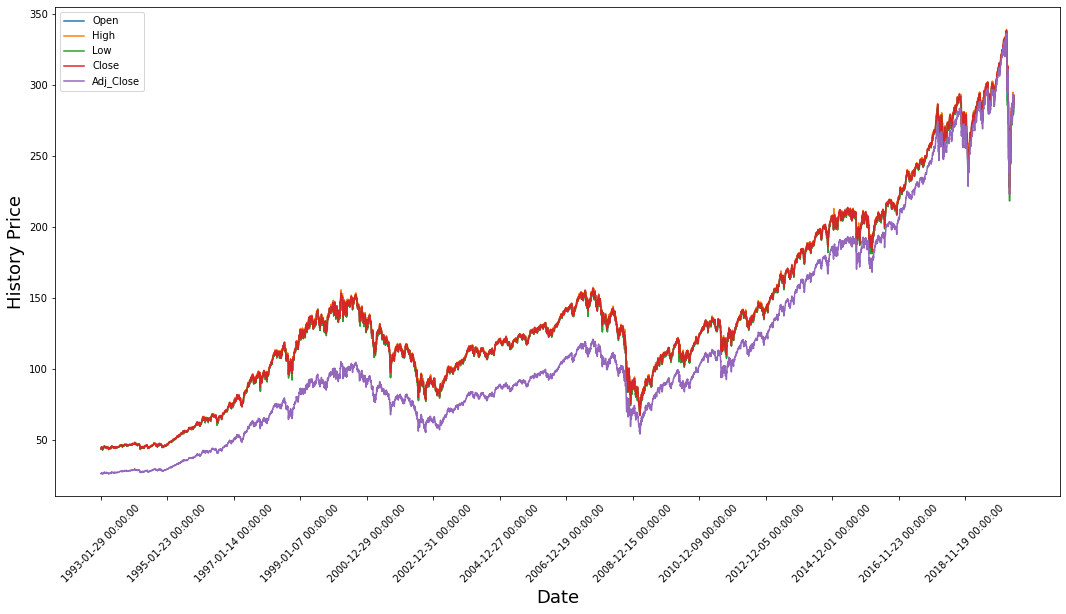

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Open']))
plt.plot(range(df.shape[0]),(df['High']))
plt.plot(range(df.shape[0]),(df['Low']))
plt.plot(range(df.shape[0]),(df['Close']))
plt.plot(range(df.shape[0]),(df['Adj_Close']))
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('History Price',fontsize=18)
plt.legend(['Open','High','Low','Close','Adj_Close'], loc='upper left')
plt.show()

<p> The trend of open, high, low, close and adj close is similar </p>

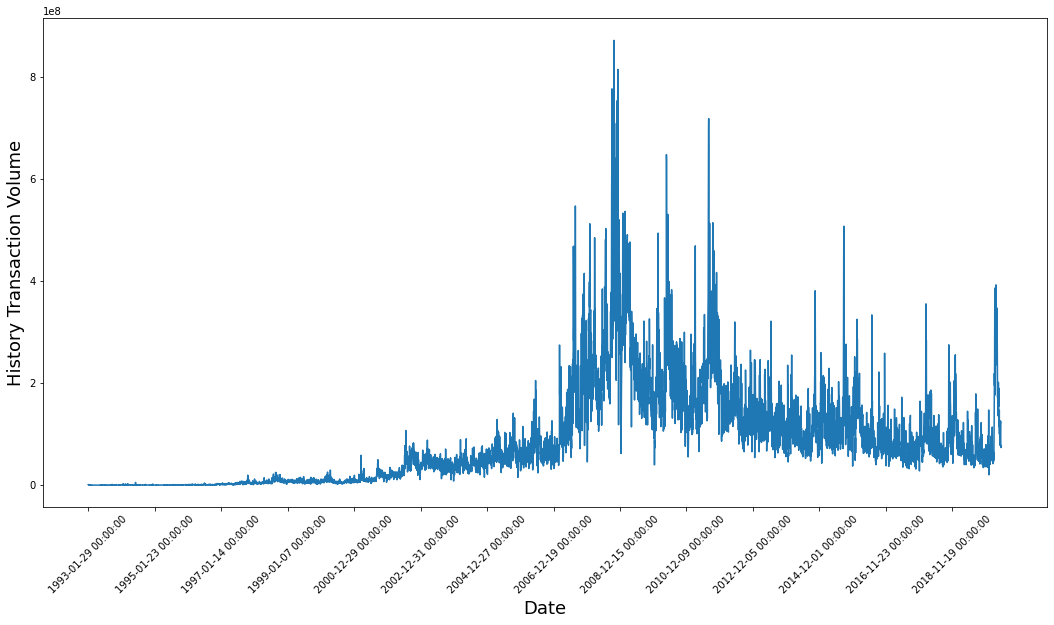

In [9]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Volume']))
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('History Transaction Volume',fontsize=18)
plt.show()

<p> It seems when there is a price drop, there is a volume surge </p>

In [10]:
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64


<h2> Normalise Data </h2>

In [0]:
# scale the feature MinMax, build array
min_max_scaler = MinMaxScaler()
cols = ['Open','High','Low','Close','Adj Close','Volume']
x = df_train.loc[:,cols].values
x_train_norm = min_max_scaler.fit_transform(x)
x_test_norm = min_max_scaler.transform(df_test.loc[:,cols].values)

<h2>Model One</h2>

In [0]:
params = {
    "batch_size": 10,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [0]:
#https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [15]:
x_temp, y_temp = build_timeseries(x_train_norm, 1)
x_train,x_val = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_train,y_val = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
x_test, y_test = build_timeseries(x_test_norm, 1)
x_test = trim_dataset(x_test, BATCH_SIZE)
y_test = trim_dataset(y_test, BATCH_SIZE)

dim_0 6468



length of time-series i/o (6468, 60, 6) (6468,)
dim_0 281



length of time-series i/o (281, 60, 6) (281,)


In [16]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3230, 60, 6)
(3230, 60, 6)
(280, 60, 6)
(3230,)
(3230,)
(280,)


In [0]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    lstm_model.summary()
    return lstm_model

In [18]:
model = None
try:
    model = pickle.load(open("data\lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Model not found


In [19]:
is_update_model = True
if model is None or is_update_model:
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)
    
    history = model.fit(x_train, y_train, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))

Building model...


AttributeError: ignored

In [0]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test, BATCH_SIZE)
error = mean_squared_error(y_test, y_pred)
print("Error is", error, y_pred.shape, y_test.shape)
print(y_pred[0:15])
print(y_test[0:15])

In [0]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[1]) + min_max_scaler.data_min_[1]*3.5
# min_max_scaler.inverse_transform(y_pred)
y_test_org = (y_test * min_max_scaler.data_range_[1]) + min_max_scaler.data_min_[1]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_org[0:15])

In [0]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig("training_data.png")

In [0]:
# load the saved best model from above
saved_model = load_model("best_model.h5") # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test = trim_dataset(y_test, BATCH_SIZE)
error = mean_squared_error(y_test, y_pred)
print("Error is", error, y_pred.shape, y_test.shape)
print(y_pred[0:15])
print(y_test[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[1]) + min_max_scaler.data_min_[1]*3.5 # min_max_scaler.inverse_transform(y_pred)
y_test_org = (y_test_t * min_max_scaler.data_range_[1]) + min_max_scaler.data_min_[1] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_org[0:15])

In [0]:
# Visualize the prediction
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig("prediction.png")

<h2> Model Two </h2>

In [0]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, foward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -foward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+foward_days)])
    return np.array(X),np.array(Y)

In [0]:
look_back = 10
foward_days = 1
x_train,y_train = processData(x_train_norm,look_back,foward_days)
y_train = np.array([list(a.ravel()) for a in y_train])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

x_test,y_test = processData(x_test_norm,look_back,foward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

In [0]:
y_train = np.delete(y_train, [0,1,2,3,5,6],axis=1)
y_val = np.delete(y_val, [0,1,2,3,5,6],axis=1)
y_test = np.delete(y_test, [0,1,2,3,5,6],axis=1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

In [0]:
NUM_NEURONS_FirstLayer = 128
NUM_NEURONS_SecondLayer = 64
EPOCHS = 220

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,6), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(foward_days))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary

history = model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),shuffle=True,batch_size=2, verbose=2)

In [0]:
plt.figure(figsize = (18,9))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [0]:

#Saving the model
file_name = root_path+'LSTM_compB_LB{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, foward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))